<a href="https://colab.research.google.com/github/NatBrian/customer-transaction/blob/main/item_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1: Cross-Domain Item Embeddings

## Overview

This notebook builds **unified item embeddings** that bridge items across multiple domains:
- Retail items (`fmcg_*`)
- Marketplace items (`nfmcg_*`)
- Offers items (`offer_*`)
- Receipt items (`approximate_item_id`)

## Why This Matters

The dataset has a critical linkage problem:
- Only ~6% of receipt items can be directly matched to catalog items
- 57-90% of brand_id values are missing in payments
- Brand embeddings are corrupted and unavailable

**Solution**: Learn embeddings from behavioral co-occurrence:
- Items purchased together (same receipt) are similar
- Items viewed together (same session) are similar

## Approach

1. **Extract co-occurrence edges** from receipts and sessions
2. **Build item vocabulary** across all domains
3. **Train contrastive embedding model** using InfoNCE loss
4. **Evaluate** via link prediction and downstream tasks
5. **Export** embeddings for use in other models

---
## Configuration and Imports

In [4]:
# Standard library
import os
import warnings
from collections import defaultdict
from typing import List, Tuple, Dict, Set

# Data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm

# ML Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
CLEANED_DATA_DIR = "cleaned_data"
OUTPUT_DIR = "models/item_embeddings"
RANDOM_SEED = 42

# Model hyperparameters
EMBEDDING_DIM = 128
BATCH_SIZE = 8192
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
NEGATIVE_SAMPLES = 5
SESSION_GAP_MINUTES = 30

# Set random seeds
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Output directory: {OUTPUT_DIR}")

Using device: cuda
Output directory: models/item_embeddings


---
## 1. Load Cleaned Data

In [5]:
def load_data():
    """Load all relevant cleaned datasets."""
    print("Loading cleaned data...")

    data = {}

    # Payments Receipts - for co-purchase edges
    # OPTIMIZATION:
    # 1. Filter out rows where brand_id is -1.0 (missing/imputed) to reduce dataset size.
    # 2. Only load columns needed for extract_copurchase_edges.
    path = os.path.join(CLEANED_DATA_DIR, 'payments_receipts_clean.parquet')
    if os.path.exists(path):
        data['receipts'] = pd.read_parquet(
            path,
            columns=['transaction_hash', 'approximate_item_id'],
            filters=[('brand_id', '!=', -1.0)]
        )
        print(f"  Receipts: {len(data['receipts']):,} records")

    # Event tables - for co-view edges
    for name, filename in [
        ('retail_events', 'retail_events_clean.parquet'),
        ('marketplace_events', 'marketplace_events_clean.parquet'),
    ]:
        path = os.path.join(CLEANED_DATA_DIR, filename)
        if os.path.exists(path):
            data[name] = pd.read_parquet(path)
            print(f"  {name}: {len(data[name]):,} records")

    # Item catalogs - for item metadata (optional enrichment)
    for name, filename in [
        ('retail_items', 'retail_items_clean.parquet'),
        ('marketplace_items', 'marketplace_items_clean.parquet'),
    ]:
        path = os.path.join(CLEANED_DATA_DIR, filename)
        if os.path.exists(path):
            data[name] = pd.read_parquet(path)
            print(f"  {name}: {len(data[name]):,} records")

    return data

data = load_data()

Loading cleaned data...
  Receipts: 8,569,179 records
  retail_events: 4,128,330 records
  marketplace_events: 5,081,920 records
  retail_items: 223,682 records
  marketplace_items: 2,325,409 records


---
## 2. Extract Co-Purchase Edges from Receipts

Items purchased in the same transaction are similar.

In [6]:
def extract_copurchase_edges(receipts: pd.DataFrame,
                              max_items_per_transaction: int = 50) -> List[Tuple[str, str]]:
    """
    Extract item pairs from the same receipt (co-purchase).

    Args:
        receipts: DataFrame with columns [transaction_hash, approximate_item_id]
        max_items_per_transaction: Skip very large transactions (noise)

    Returns:
        List of (item1, item2) pairs
    """
    print("Extracting co-purchase edges from receipts...")

    edges = []
    skipped_transactions = 0

    # Group by transaction
    for tx_hash, group in tqdm(receipts.groupby('transaction_hash'),
                                desc="Processing transactions"):
        items = group['approximate_item_id'].unique().tolist()

        # Skip very large transactions (likely data issues or batch orders)
        if len(items) > max_items_per_transaction:
            skipped_transactions += 1
            continue

        # Create all pairs within this transaction
        for i in range(len(items)):
            for j in range(i + 1, len(items)):
                edges.append((str(items[i]), str(items[j])))

    print(f"  Extracted {len(edges):,} co-purchase edges")
    print(f"  Skipped {skipped_transactions} large transactions")

    return edges

copurchase_edges = extract_copurchase_edges(data['receipts'])

Extracting co-purchase edges from receipts...


Processing transactions: 100%|██████████| 4544444/4544444 [05:16<00:00, 14373.34it/s]

  Extracted 7,942,265 co-purchase edges
  Skipped 10 large transactions


---
## 3. Extract Co-View Edges from Sessions

Items viewed in the same session are related.

In [7]:
def reconstruct_sessions(events: pd.DataFrame,
                          gap_minutes: int = SESSION_GAP_MINUTES) -> pd.DataFrame:
    """
    Reconstruct sessions from event stream.

    Sessions are defined as sequences of events from the same user
    with less than `gap_minutes` between consecutive events.
    """
    events = events.sort_values(['user_id', 'timestamp'])

    # Calculate time difference between consecutive events per user
    events['time_diff'] = events.groupby('user_id')['timestamp'].diff()

    # Mark session breaks (gap > threshold OR first event per user)
    gap_threshold = pd.Timedelta(minutes=gap_minutes)
    events['session_break'] = (
        events['time_diff'].isna() |
        (events['time_diff'] > gap_threshold)
    )

    # Assign session IDs
    events['session_id'] = events['session_break'].cumsum()

    return events


def extract_coview_edges(events: pd.DataFrame,
                          max_items_per_session: int = 30,
                          gap_minutes: int = SESSION_GAP_MINUTES) -> List[Tuple[str, str]]:
    """
    Extract item pairs viewed in the same session (co-view).
    """
    print(f"Extracting co-view edges (session gap = {gap_minutes} min)...")

    # Reconstruct sessions
    events_with_sessions = reconstruct_sessions(events, gap_minutes)

    edges = []
    skipped_sessions = 0

    # Group by session
    for session_id, group in tqdm(events_with_sessions.groupby('session_id'),
                                   desc="Processing sessions"):
        items = group['item_id'].unique().tolist()

        # Skip very long sessions (likely data issues or bots)
        if len(items) > max_items_per_session:
            skipped_sessions += 1
            continue

        # Create all pairs within this session
        for i in range(len(items)):
            for j in range(i + 1, len(items)):
                edges.append((str(items[i]), str(items[j])))

    print(f"  Extracted {len(edges):,} co-view edges")
    print(f"  Skipped {skipped_sessions} long sessions")

    return edges

# Extract from retail events
retail_coview_edges = extract_coview_edges(data['retail_events'])

# Extract from marketplace events
marketplace_coview_edges = extract_coview_edges(data['marketplace_events'])

Extracting co-view edges (session gap = 30 min)...


Processing sessions: 100%|██████████| 64568/64568 [00:05<00:00, 10799.26it/s]


  Extracted 397,824 co-view edges
  Skipped 2210 long sessions
Extracting co-view edges (session gap = 30 min)...


Processing sessions: 100%|██████████| 2432695/2432695 [03:46<00:00, 10720.49it/s]


  Extracted 5,820,922 co-view edges
  Skipped 8789 long sessions


---
## 4. Build Item Vocabulary

In [8]:
def build_vocabulary(all_edges: List[Tuple[str, str]]) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Build item vocabulary from all edges.

    Returns:
        item_to_idx: mapping from item_id to integer index
        idx_to_item: reverse mapping
    """
    # Collect all unique items
    all_items = set()
    for item1, item2 in all_edges:
        all_items.add(item1)
        all_items.add(item2)

    # Create mappings
    sorted_items = sorted(list(all_items))
    item_to_idx = {item: idx for idx, item in enumerate(sorted_items)}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    return item_to_idx, idx_to_item

# Combine all edges
all_edges = copurchase_edges + retail_coview_edges + marketplace_coview_edges
print(f"\nTotal edges: {len(all_edges):,}")

# Build vocabulary
item_to_idx, idx_to_item = build_vocabulary(all_edges)
vocab_size = len(item_to_idx)
print(f"Vocabulary size: {vocab_size:,} unique items")

# Analyze item types
item_types = defaultdict(int)
for item in item_to_idx.keys():
    if item.startswith('fmcg_'):
        item_types['retail (fmcg)'] += 1
    elif item.startswith('nfmcg_'):
        item_types['marketplace (nfmcg)'] += 1
    elif item.startswith('offer_'):
        item_types['offers'] += 1
    else:
        item_types['receipt (approx)'] += 1

print("\nItem distribution by domain:")
for domain, count in sorted(item_types.items()):
    print(f"  {domain}: {count:,} ({count/vocab_size*100:.1f}%)")


Total edges: 14,161,011
Vocabulary size: 456,186 unique items

Item distribution by domain:
  marketplace (nfmcg): 327,145 (71.7%)
  retail (fmcg): 129,041 (28.3%)


---
## 5. Prepare Training Data

In [9]:
class ContrastiveDataset(Dataset):
    """
    Dataset for contrastive learning.
    Optimized to store data as tensors.
    """

    def __init__(self, edges: List[Tuple[str, str]], item_to_idx: Dict[str, int]):
        self.item_to_idx = item_to_idx

        # Convert edges to indices
        edge_pairs = []
        for item1, item2 in edges:
            if item1 in item_to_idx and item2 in item_to_idx:
                idx1 = item_to_idx[item1]
                idx2 = item_to_idx[item2]
                # Add both directions for symmetry
                edge_pairs.append((idx1, idx2))
                edge_pairs.append((idx2, idx1))

        # Store as tensor for efficiency
        self.edge_pairs = torch.tensor(edge_pairs, dtype=torch.long)

        print(f"Dataset created with {len(self.edge_pairs):,} training pairs")

    def __len__(self):
        return len(self.edge_pairs)

    def __getitem__(self, idx):
        return self.edge_pairs[idx][0], self.edge_pairs[idx][1]


# Create dataset
dataset = ContrastiveDataset(all_edges, item_to_idx)

# Split into train/val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"Train: {len(train_dataset):,} pairs")
print(f"Val: {len(val_dataset):,} pairs")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Dataset created with 28,322,022 training pairs
Train: 25,489,819 pairs
Val: 2,832,203 pairs


---
## 6. Define Contrastive Model

We use a simple embedding model with InfoNCE (contrastive) loss.

In [10]:
class ItemEmbeddingModel(nn.Module):
    """
    Simple item embedding model with projection head.

    Architecture:
        item_id -> Embedding(vocab_size, embed_dim) -> ProjectionHead -> normalized embedding
    """

    def __init__(self, vocab_size: int, embed_dim: int = EMBEDDING_DIM):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Projection head (improves contrastive learning)
        self.projection = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        # Initialize embeddings
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, item_ids):
        """Get projected embeddings for item IDs."""
        x = self.embedding(item_ids)
        x = self.projection(x)
        # L2 normalize for cosine similarity
        x = F.normalize(x, dim=-1)
        return x

    def get_embeddings(self, item_ids):
        """Get raw embeddings (without projection) for inference."""
        with torch.no_grad():
            return self.embedding(item_ids)


def info_nce_loss(anchor_emb, positive_emb, temperature=0.1):
    """
    InfoNCE contrastive loss.

    Maximizes similarity between anchor and positive,
    minimizes similarity to other items in the batch (in-batch negatives).
    """
    # Compute similarity matrix [batch_size, batch_size]
    similarity = torch.matmul(anchor_emb, positive_emb.T) / temperature

    # Labels: diagonal elements are positive pairs
    labels = torch.arange(similarity.size(0), device=similarity.device)

    # Cross-entropy loss (treat as classification: which positive matches anchor?)
    loss = F.cross_entropy(similarity, labels)

    return loss


# Create model
model = ItemEmbeddingModel(vocab_size, EMBEDDING_DIM).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Model created with 58,424,832 parameters
Embedding dimension: 128


---
## 7. Training Loop

In [12]:
def train_epoch(model, train_loader, optimizer, device, scaler):
    """Train for one epoch with Mixed Precision."""
    model.train()
    total_loss = 0
    num_batches = 0

    # Add progress bar for training batches
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for anchor_ids, positive_ids in pbar:
        anchor_ids = anchor_ids.to(device)
        positive_ids = positive_ids.to(device)

        # Mixed Precision Training
        with torch.cuda.amp.autocast():
            # Forward pass
            anchor_emb = model(anchor_ids)
            positive_emb = model(positive_ids)

            # Compute loss
            loss = info_nce_loss(anchor_emb, positive_emb)

        # Backward pass with scaler
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        num_batches += 1

        # Update progress bar with current loss
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / num_batches


def evaluate(model, val_loader, device):
    """Evaluate on validation set."""
    model.eval()
    total_loss = 0
    num_batches = 0

    # Add progress bar for validation
    pbar = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for anchor_ids, positive_ids in pbar:
            anchor_ids = anchor_ids.to(device)
            positive_ids = positive_ids.to(device)

            anchor_emb = model(anchor_ids)
            positive_emb = model(positive_ids)

            loss = info_nce_loss(anchor_emb, positive_emb)
            total_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / num_batches


# Training
print("\n" + "="*60)
print("TRAINING")
print("="*60)
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Epochs: {NUM_EPOCHS}")
print()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)
scaler = torch.cuda.amp.GradScaler()

history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss = train_epoch(model, train_loader, optimizer, device, scaler)
    val_loss = evaluate(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Save best model
    saved_marker = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pt'))
        saved_marker = "saved"

    # Print epoch summary
    lr_change = f" (lr: {old_lr:.6f} → {new_lr:.6f})" if old_lr != new_lr else ""
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}{lr_change}{saved_marker}")
    print()

print(f"Best validation loss: {best_val_loss:.4f}")


TRAINING
Train batches: 3,112
Val batches: 346
Epochs: 5

Epoch 1/5


  Train Loss: 6.8091 | Val Loss: 6.4122saved

Epoch 2/5


  Train Loss: 6.3081 | Val Loss: 6.3061saved

Epoch 3/5


  Train Loss: 6.2275 | Val Loss: 6.2641saved

Epoch 4/5


  Train Loss: 6.1876 | Val Loss: 6.2426saved

Epoch 5/5


  Train Loss: 6.1628 | Val Loss: 6.2285saved

Best validation loss: 6.2285


---
## 8. Training Visualization

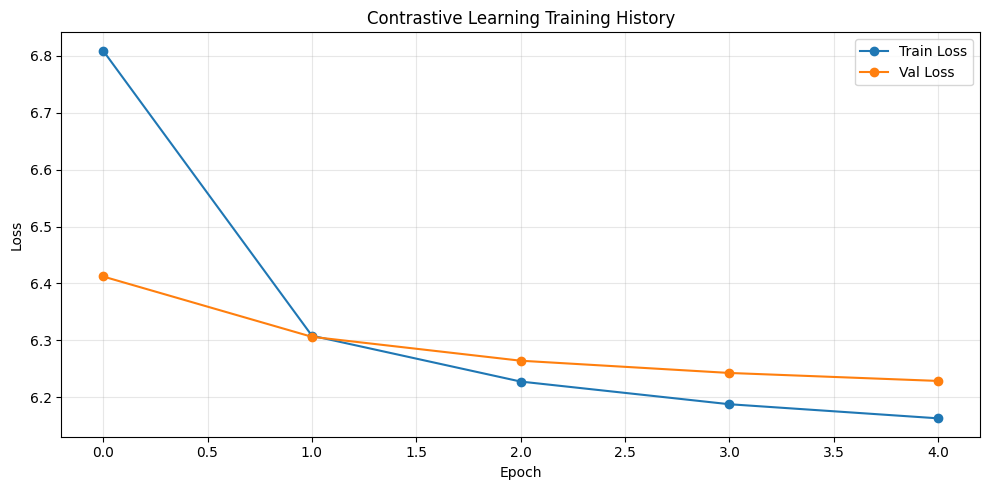

Saved: models/item_embeddings/training_history.png


In [13]:
# Plot training history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['train_loss'], label='Train Loss', marker='o')
ax.plot(history['val_loss'], label='Val Loss', marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Contrastive Learning Training History')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()
print(f"Saved: {OUTPUT_DIR}/training_history.png")

---
## 9. Export Embeddings

In [14]:
def export_embeddings(model, item_to_idx, idx_to_item, output_dir):
    """Export trained embeddings to parquet file."""
    print("Exporting embeddings...")

    # Load best model
    model.load_state_dict(torch.load(os.path.join(output_dir, 'best_model.pt')))
    model.eval()

    # Get all item indices
    all_indices = torch.arange(len(item_to_idx), device=device)

    # Get embeddings in batches
    embeddings_list = []
    batch_size = 10000

    with torch.no_grad():
        for i in tqdm(range(0, len(all_indices), batch_size), desc="Exporting"):
            batch_indices = all_indices[i:i+batch_size]
            batch_embeddings = model.get_embeddings(batch_indices)
            embeddings_list.append(batch_embeddings.cpu().numpy())

    # Combine
    all_embeddings = np.vstack(embeddings_list)

    # Create DataFrame
    embedding_df = pd.DataFrame({
        'item_id': [idx_to_item[i] for i in range(len(item_to_idx))],
        'embedding': list(all_embeddings)
    })

    # Add item metadata
    def get_item_domain(item_id):
        if item_id.startswith('fmcg_'):
            return 'retail'
        elif item_id.startswith('nfmcg_'):
            return 'marketplace'
        elif item_id.startswith('offer_'):
            return 'offers'
        else:
            return 'receipt'

    embedding_df['domain'] = embedding_df['item_id'].apply(get_item_domain)

    # Save
    output_path = os.path.join(output_dir, 'item_embeddings.parquet')
    embedding_df.to_parquet(output_path, index=False)
    print(f"Saved {len(embedding_df):,} embeddings to {output_path}")

    # Also save vocabulary mapping
    vocab_path = os.path.join(output_dir, 'item_vocabulary.parquet')
    vocab_df = pd.DataFrame({
        'item_id': list(item_to_idx.keys()),
        'index': list(item_to_idx.values())
    })
    vocab_df.to_parquet(vocab_path, index=False)
    print(f"Saved vocabulary to {vocab_path}")

    return embedding_df

embedding_df = export_embeddings(model, item_to_idx, idx_to_item, OUTPUT_DIR)

Exporting embeddings...


Exporting: 100%|██████████| 46/46 [00:00<00:00, 233.37it/s]


Saved 456,186 embeddings to models/item_embeddings/item_embeddings.parquet
Saved vocabulary to models/item_embeddings/item_vocabulary.parquet


---
## 10. Evaluation: Similarity Analysis

In [15]:
def find_similar_items(query_item: str,
                       embedding_df: pd.DataFrame,
                       top_k: int = 10) -> pd.DataFrame:
    """Find most similar items to a query item."""
    if query_item not in item_to_idx:
        print(f"Item {query_item} not in vocabulary")
        return None

    # Get query embedding
    query_idx = embedding_df[embedding_df['item_id'] == query_item].index[0]
    query_emb = np.array(embedding_df.iloc[query_idx]['embedding'])

    # Compute similarities
    all_embeddings = np.vstack(embedding_df['embedding'].values)
    similarities = np.dot(all_embeddings, query_emb)

    # Get top-k (excluding query itself)
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]

    result = embedding_df.iloc[top_indices][['item_id', 'domain']].copy()
    result['similarity'] = similarities[top_indices]

    return result


# Demonstrate with sample items from each domain
print("\n" + "="*60)
print("SIMILARITY ANALYSIS")
print("="*60)

# Find a sample item from each domain
sample_items = {}
for domain in ['retail', 'marketplace', 'receipt']:
    domain_items = embedding_df[embedding_df['domain'] == domain]['item_id'].values
    if len(domain_items) > 0:
        sample_items[domain] = domain_items[0]

for domain, item_id in sample_items.items():
    print(f"\n{domain.upper()} item: {item_id}")
    similar = find_similar_items(item_id, embedding_df, top_k=5)
    if similar is not None:
        print(similar.to_string(index=False))


SIMILARITY ANALYSIS

RETAIL item: fmcg_10
       item_id      domain  similarity
       fmcg_10      retail    0.574482
 nfmcg_4552094 marketplace    0.503533
   fmcg_543966      retail    0.486035
nfmcg_10325173 marketplace    0.479256
nfmcg_13421375 marketplace    0.476937

MARKETPLACE item: nfmcg_10000098
       item_id      domain  similarity
 nfmcg_7492911 marketplace    0.995198
 nfmcg_1619744 marketplace    0.991276
nfmcg_13670383 marketplace    0.986789
nfmcg_10000098 marketplace    0.984555
nfmcg_21749676 marketplace    0.958110


---
## 11. Evaluation: Cross-Domain Linkage

In [16]:
def analyze_cross_domain_links(embedding_df: pd.DataFrame,
                                threshold: float = 0.8) -> pd.DataFrame:
    """
    Find cross-domain item links based on embedding similarity.

    This helps solve the receipt-to-catalog matching problem:
    which receipt items (approximate_item_id) are similar to catalog items?
    """
    print(f"\nAnalyzing cross-domain links (similarity threshold = {threshold})...")

    # Get receipt items
    receipt_items = embedding_df[embedding_df['domain'] == 'receipt']
    catalog_items = embedding_df[embedding_df['domain'].isin(['retail', 'marketplace'])]

    print(f"  Receipt items: {len(receipt_items):,}")
    print(f"  Catalog items: {len(catalog_items):,}")

    if len(receipt_items) == 0 or len(catalog_items) == 0:
        print("  No cross-domain pairs possible")
        return None

    # Compute similarity matrix (sample for efficiency)
    max_receipt = min(10000, len(receipt_items))
    receipt_sample = receipt_items.sample(n=max_receipt, random_state=RANDOM_SEED)

    receipt_embs = np.vstack(receipt_sample['embedding'].values)
    catalog_embs = np.vstack(catalog_items['embedding'].values)

    # Find best catalog match for each receipt item
    links = []
    for i, (_, row) in enumerate(tqdm(receipt_sample.iterrows(),
                                        total=len(receipt_sample),
                                        desc="Matching")):
        receipt_emb = np.array(row['embedding'])
        sims = np.dot(catalog_embs, receipt_emb)
        best_idx = np.argmax(sims)
        best_sim = sims[best_idx]

        if best_sim >= threshold:
            links.append({
                'receipt_item': row['item_id'],
                'catalog_item': catalog_items.iloc[best_idx]['item_id'],
                'catalog_domain': catalog_items.iloc[best_idx]['domain'],
                'similarity': best_sim
            })

    links_df = pd.DataFrame(links)
    print(f"\n  Found {len(links_df):,} high-confidence matches ({len(links_df)/max_receipt*100:.1f}%)")

    if len(links_df) > 0:
        print(f"\n  Sample matches:")
        print(links_df.head(10).to_string(index=False))

    return links_df

cross_domain_links = analyze_cross_domain_links(embedding_df, threshold=0.7)

# Save links
if cross_domain_links is not None and len(cross_domain_links) > 0:
    links_path = os.path.join(OUTPUT_DIR, 'cross_domain_links.parquet')
    cross_domain_links.to_parquet(links_path, index=False)
    print(f"\nSaved cross-domain links to {links_path}")


Analyzing cross-domain links (similarity threshold = 0.7)...
  Receipt items: 0
  Catalog items: 456,186
  No cross-domain pairs possible


---
## 12. Summary and Next Steps

In [17]:
print("\n" + "="*80)
print("CROSS-DOMAIN ITEM EMBEDDINGS - SUMMARY")
print("="*80)

print(f"""
## Training Results

- Vocabulary size: {vocab_size:,} unique items
- Embedding dimension: {EMBEDDING_DIM}
- Final validation loss: {history['val_loss'][-1]:.4f}
- Best validation loss: {best_val_loss:.4f}

## Output Files

- {OUTPUT_DIR}/best_model.pt - Trained PyTorch model
- {OUTPUT_DIR}/item_embeddings.parquet - Item embeddings ({len(embedding_df):,} items)
- {OUTPUT_DIR}/item_vocabulary.parquet - Item ID to index mapping
- {OUTPUT_DIR}/cross_domain_links.parquet - Receipt-to-catalog matches
- {OUTPUT_DIR}/training_history.png - Training curves

## Item Distribution

""")

for domain, count in embedding_df['domain'].value_counts().items():
    print(f"  {domain}: {count:,} ({count/len(embedding_df)*100:.1f}%)")

print(f"""

## Next Steps (Use These Embeddings In)

1. **Model 2: Conversion Prediction**
   - Average embeddings of viewed/purchased items per user
   - Use as user representation features

2. **Model 4: Session Ranking**
   - Use embeddings for candidate retrieval (ANN)
   - Initialize session transformer with pre-trained embeddings

3. **Data Quality**
   - Use cross_domain_links to enrich receipts with catalog metadata
   - Enables brand/category analysis on payment data
""")

print("="*80)
print("Model 1 training complete!")
print("="*80)


CROSS-DOMAIN ITEM EMBEDDINGS - SUMMARY

## Training Results

- Vocabulary size: 456,186 unique items
- Embedding dimension: 128
- Final validation loss: 6.2285
- Best validation loss: 6.2285

## Output Files

- models/item_embeddings/best_model.pt - Trained PyTorch model
- models/item_embeddings/item_embeddings.parquet - Item embeddings (456,186 items)
- models/item_embeddings/item_vocabulary.parquet - Item ID to index mapping
- models/item_embeddings/cross_domain_links.parquet - Receipt-to-catalog matches
- models/item_embeddings/training_history.png - Training curves

## Item Distribution


  marketplace: 327,145 (71.7%)
  retail: 129,041 (28.3%)


## Next Steps (Use These Embeddings In)

1. **Model 2: Conversion Prediction**
   - Average embeddings of viewed/purchased items per user
   - Use as user representation features

2. **Model 4: Session Ranking**
   - Use embeddings for candidate retrieval (ANN)
   - Initialize session transformer with pre-trained embeddings

3. **Data Qua